# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 13 at 5pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

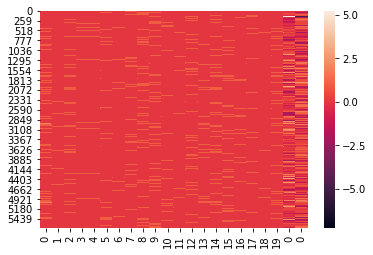

In [22]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

### READ AND CLEAN DATA ###
data = []
for line in open('business.json', 'r'):
    data.append(json.loads(line))
    
dataframe = pd.DataFrame(data)

dataframe = dataframe.loc[dataframe['city']=='Las Vegas']

#reset index
dataframe = dataframe.reset_index(drop='True')

#remove the spaces from the categories
for k in range(len(dataframe['categories'])):
    for x in range(len(dataframe['categories'][k])):
        dataframe['categories'][k][x] = dataframe['categories'][k][x].replace(" ", "")
        
#create a space-separated string from the category lists
dataframe['categories'] = dataframe['categories'].apply(lambda x: ' '.join(x))

#now filter for restaurants
dataframe = dataframe.loc[dataframe['categories'].apply(lambda x: 'Restaurants' in x)]

#to avoid distortion, remove restaurants and food from the strings altogeth
dataframe['categories'] = dataframe['categories'].apply(lambda x: x.replace("Restaurants", ""))

#reset index
dataframe = dataframe.reset_index(drop='True')

### PREPARE THE CLUSTERING MATRIX ###

#create a vectorizer for the text fields
vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(dataframe['categories'])

#scale the longitude and latitude values
lat_scaled = pd.DataFrame(preprocessing.scale(dataframe['latitude']))
long_scaled = pd.DataFrame(preprocessing.scale(dataframe['longitude']))
lat_long_scaled = pd.concat([lat_scaled, long_scaled], axis=1)

#concatenate the two frames to make the clustering matrix
cluster_matrix = pd.concat([pd.DataFrame(X.toarray()), lat_long_scaled], axis=1)

#quick sanity check with a heatmap visualization
import seaborn as sns
_ = sns.heatmap(cluster_matrix)

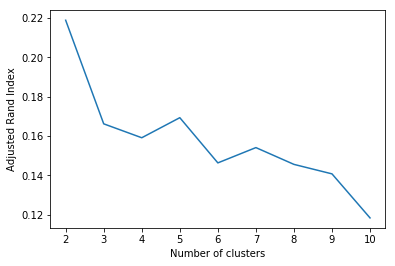

In [23]:
### K-MEANS CLUSTERING ###

#determine the optimal number of clusters
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()
    
sc_evaluate_clusters(cluster_matrix,10)

Based on this graph, it appears 5 is the optimal number of clusters.

In [24]:
#perform k-means with 5 clusters
k=5
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, )
kmeans.fit_predict(cluster_matrix)

asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
order_centroids[1]

#top terms per cluster
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster {}:".format(i))
    for ind in order_centroids[i, :10]:
        if ind < 20:
            print(' {}'.format(terms[ind]))
    print('')

Top terms per cluster:
Cluster 0:
 food
 fastfood
 american
 sandwiches
 pizza
 nightlife
 mexican
 chinese
 bars
 japanese

Cluster 1:
 fastfood
 food
 sandwiches
 pizza
 mexican
 american
 burgers
 nightlife
 bars

Cluster 2:
 fastfood
 american
 food
 mexican
 pizza
 traditional
 sandwiches
 burgers
 nightlife

Cluster 3:
 american
 traditional
 new
 nightlife
 bars
 food
 breakfast
 brunch
 burgers

Cluster 4:
 food
 mexican
 fastfood
 sandwiches
 pizza
 nightlife
 chinese
 bars



I represented the similarity matrix as a vectorized matrix of the top 20 terms (excluding 'restaurants' itself) from all of the restaurants in Las Vegas, and then i tacked on a normalized latitude and longitude to the similarity dataframe. I tried scaling the latitude and longitude by a factor of three, but it didn't seem to make much difference. 

One caveat I ran into that it would be interesting to unpack is that the count vectorized word data and the lat-long coordinates are probably best suited to different distance metrics. For instance, Hamming distance is probably well-suited to the word data as the number of identical words in each restaurants categories field is a decent measure of similarity between the resturants. Of course, this would tend to favor restaurants with more categories even if a lower percentage were the same, so we would probably have to do some normalization or create our own custom metric. 

On the other hand, the lat-long data is well-suited to a pairwise Euclidean distance metric, since the coordinates represent real space. Since both types of data were contained in the same clustering dataframe, we did not have the freedom to use different types of metrics to cluster each respective characteristic. 

I used silhouette score to determine number of clusters in k-means and hierarchical clustering, and decided on ward's method for the linkage in hierarchical clustering beacuse it seemed to balance the tradeoffs of the other linkages. 

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

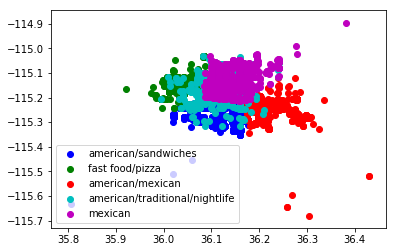

In [25]:
#KMeans plot
import matplotlib
#plot and label the kmeans clusters
labels = kmeans.labels_
#create field for cluster number in k-means
dataframe['k_cluster'] = labels

%matplotlib inline 

#plot clusters
plt.scatter(dataframe['latitude'][dataframe['k_cluster']==0],
            dataframe['longitude'][dataframe['k_cluster']==0],
            c='b',
           label = 'american/sandwiches')
plt.scatter(dataframe['latitude'][dataframe['k_cluster']==1],
            dataframe['longitude'][dataframe['k_cluster']==1],
            c='g',
           label = 'fast food/pizza')
plt.scatter(dataframe['latitude'][dataframe['k_cluster']==2],
            dataframe['longitude'][dataframe['k_cluster']==2],
            c='r',
           label = 'american/mexican')
plt.scatter(dataframe['latitude'][dataframe['k_cluster']==3],
            dataframe['longitude'][dataframe['k_cluster']==3],
            c='c',
           label = 'american/traditional/nightlife')
plt.scatter(dataframe['latitude'][dataframe['k_cluster']==4],
            dataframe['longitude'][dataframe['k_cluster']==4],
            c='m',
           label = 'mexican')
plt.legend()
plt.show() #show the plot

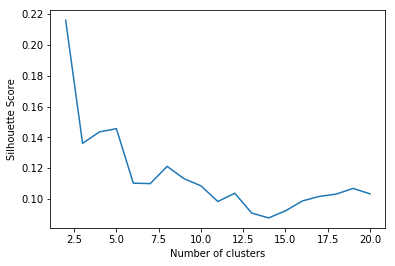

In [27]:
### HIERARCHICAL CLUSTERING ###
import scipy as sp
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance

hierarchy_cluster = hierarchy.linkage(cluster_matrix, method='ward', metric='euclidean')
### DETERMING NUMBER OF CLUSTERS ###

max_clusters = 20
s = np.zeros(max_clusters+1)
for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(hierarchy_cluster, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(cluster_matrix,clusters,metric='euclidean')
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

5 also appears to be the optimal cluster number for hierarchical clustering

In [28]:
hk = 5
clusters = hierarchy.fcluster(hierarchy_cluster, hk, criterion='maxclust')
dataframe['h_cluster'] = clusters

#find hierarchical centroids
grouped_h_cluster_matrix = cluster_matrix.copy()
grouped_h_cluster_matrix['groups'] = clusters
grouped_h_cluster_matrix.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'groups']
names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v']
h_centroids = grouped_h_cluster_matrix.groupby('groups')[names].mean()
h_centroids = h_centroids.as_matrix()

#find top terms per hierarchical cluster
print("Top terms per cluster:")
H_asc_order_centroids = h_centroids.argsort()#[:, ::-1]
h_order_centroids = H_asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(hk):
    print("Cluster {}:".format(i))
    for ind in h_order_centroids[i, :10]:
        if ind < 20:
            print(' {}'.format(terms[ind]))
    print('')

Top terms per cluster:
Cluster 0:
 mexican
 fastfood
 food
 pizza
 sandwiches
 american
 nightlife
 bars
 burgers

Cluster 1:
 american
 food
 traditional
 new
 nightlife
 fastfood
 bars
 breakfast
 brunch
 burgers

Cluster 2:
 food
 fastfood
 mexican
 chinese
 nightlife
 pizza
 bars
 sandwiches
 burgers

Cluster 3:
 fastfood
 food
 sandwiches
 pizza
 mexican
 japanese
 italian
 burgers
 sushibars
 asianfusion

Cluster 4:
 american
 traditional
 new
 nightlife
 bars
 breakfast
 brunch
 food
 burgers



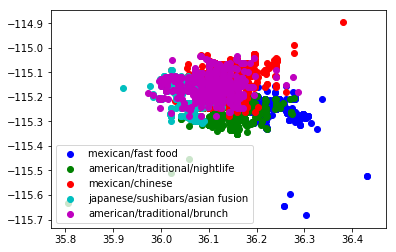

In [30]:
#plot the clusters

%matplotlib inline 


#plot clusters
plt.scatter(dataframe['latitude'][dataframe['h_cluster']==1],
            dataframe['longitude'][dataframe['h_cluster']==1],
            c='b',
           label = 'mexican/fast food')
plt.scatter(dataframe['latitude'][dataframe['h_cluster']==2],
            dataframe['longitude'][dataframe['h_cluster']==2],
            c='g',
           label = 'american/traditional/nightlife')
plt.scatter(dataframe['latitude'][dataframe['h_cluster']==3],
            dataframe['longitude'][dataframe['h_cluster']==3],
            c='r',
           label = 'mexican/chinese')
plt.scatter(dataframe['latitude'][dataframe['h_cluster']==4],
            dataframe['longitude'][dataframe['h_cluster']==4],
            c='c',
           label = 'japanese/sushibars/asian fusion')
plt.scatter(dataframe['latitude'][dataframe['h_cluster']==5],
            dataframe['longitude'][dataframe['h_cluster']==5],
            c='m',
           label = 'american/traditional/brunch')
plt.legend()
plt.show() #show the plot


In [31]:
### GMM CLUSTERING ###
import time
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

# Fit a mixture of Gaussians with EM using two components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(cluster_matrix)
y_pred = gmm.predict(cluster_matrix)
y_pred
dataframe['gmm_cluster'] = y_pred
#find gmm centroids
grouped_gmm_cluster_matrix = cluster_matrix.copy()
grouped_gmm_cluster_matrix['groups'] = y_pred
grouped_gmm_cluster_matrix.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'groups']
names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v']
gmm_centroids = grouped_gmm_cluster_matrix.groupby('groups')[names].mean()
gmm_centroids = gmm_centroids.as_matrix()
#find top terms per gmm cluster
print("Top terms per cluster:")
GMM_asc_order_centroids = gmm_centroids.argsort()#[:, ::-1]
gmm_order_centroids = GMM_asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster {}:".format(i))
    for ind in gmm_order_centroids[i, :10]:
        if ind < 20:
            print(' {}'.format(terms[ind]))
    print('')

Top terms per cluster:
Cluster 0:
 mexican
 chinese
 italian
 food
 asianfusion
 pizza
 japanese
 bars
 nightlife
 seafood

Cluster 1:
 sushibars
 nightlife
 asianfusion
 american
 food
 japanese
 new
 seafood
 cafes
 bars

Cluster 2:
 pizza
 mexican
 fastfood
 sushibars
 japanese
 food
 sandwiches
 nightlife
 bars
 american

Cluster 3:
 american
 food
 traditional
 fastfood
 sandwiches
 bars
 nightlife
 new
 burgers
 breakfast

Cluster 4:
 american
 italian
 new
 pizza
 traditional
 sandwiches
 food
 mexican
 nightlife
 bars



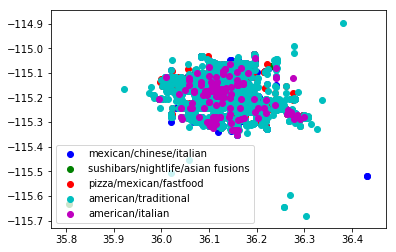

In [32]:
#plot gmm clusters
#plot the clusters

%matplotlib inline 


#plot clusters
plt.scatter(dataframe['latitude'][dataframe['gmm_cluster']==0],
            dataframe['longitude'][dataframe['gmm_cluster']==0],
            c='b',
           label = 'mexican/chinese/italian')
plt.scatter(dataframe['latitude'][dataframe['gmm_cluster']==1],
            dataframe['longitude'][dataframe['gmm_cluster']==1],
            c='g',
           label = 'sushibars/nightlife/asian fusions')
plt.scatter(dataframe['latitude'][dataframe['gmm_cluster']==2],
            dataframe['longitude'][dataframe['gmm_cluster']==2],
            c='r',
           label = 'pizza/mexican/fastfood')
plt.scatter(dataframe['latitude'][dataframe['gmm_cluster']==3],
            dataframe['longitude'][dataframe['gmm_cluster']==3],
            c='c',
           label = 'american/traditional')
plt.scatter(dataframe['latitude'][dataframe['gmm_cluster']==4],
            dataframe['longitude'][dataframe['gmm_cluster']==4],
            c='m',
           label = 'american/italian')
plt.legend()
plt.show() #show the plot

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [33]:
### K MEANS OUTLIERS ###
from scipy.spatial import distance
#create a vector of distances from respective centroids
labels = kmeans.labels_
k_cluster_matrix = cluster_matrix.copy()
k_cluster_matrix['labels'] = labels
kmeans_dists = pd.DataFrame(index = range(0, 5682, 1), columns = ['dist'])

for i in range(len(cluster_matrix)):
    clust = k_cluster_matrix['labels'][i]
    kmeans_dists.iloc[i]['dist'] = distance.euclidean(k_cluster_matrix.iloc[i][:22].as_matrix(), kmeans.cluster_centers_[clust])


k_std = np.std(kmeans_dists['dist'])
k_mean = np.mean(kmeans_dists['dist'])
#these are the furthest points from the centroids
k_furthest = kmeans_dists['dist'].loc[kmeans_dists['dist']>k_mean+4*k_std]
k_furthest_idx = k_furthest.index
dataframe.iloc[k_furthest_idx]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,k_cluster,h_cluster,gmm_cluster
166,,"{'GoodForMeal': {'dessert': False, 'latenight'...",wGSx98wpsI7dijynSNxR1A,Food FoodTrucks Mexican Seafood,Las Vegas,"{'Monday': '10:00-15:00', 'Tuesday': '10:00-15...",0,36.430308,-115.520736,Los Amigos,,89166,6,4.5,NV,2,1,0
1006,2 Kyle Canyon Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",hwJdv1tttvynXo2LZjJ6rg,Steakhouses American(Traditional),Las Vegas,"{'Monday': '7:00-20:00', 'Tuesday': '7:00-20:0...",1,36.269479,-115.594566,A Cut Above Steakhouse,,89124,24,2.0,NV,2,1,3
1229,2880 Las Vegas Blvd S,"{'NoiseLevel': 'very_loud', 'Music': {'dj': Fa...",FFXdXv0J6weMdXoUErGbpQ,Nightlife Karaoke Breakfast&Brunch Food,Las Vegas,{},1,35.805672,-115.634240,Vince Neil's Tatuado,,89109,4,3.5,NV,0,2,1
1370,5375 Kyle Canyon Rd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",XhgFynFD7ZT77wofWpeOag,Bars Nightlife Burgers American(Traditional) ...,Las Vegas,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-20:0...",1,36.257639,-115.644741,Mt Charleston Lodge Restaurant,,89124,228,3.5,NV,2,1,3
1581,"The M Resort Hotel & Casino, 12300 Las Vegas B...","{'GoodForMeal': {'dessert': False, 'latenight'...",deI84pfI76aKNBckQBPwhA,Seafood,Las Vegas,{},0,36.277893,-114.990351,The Oyster Bar at Terzetto,,89124,4,4.0,NV,4,3,3
1619,,"{'BusinessAcceptsCreditCards': True, 'Restaura...",OokdfOqprBP7fgR_RFADng,Caterers EventPlanning&Services Food Mexican ...,Las Vegas,"{'Friday': '11:00-13:00', 'Tuesday': '11:00-13...",1,36.430308,-115.520736,A1 Mobile Catering,,89166,4,4.0,NV,2,1,0
1891,6825 Speedway Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",IYydfjUO5kb-N4KwSPlEcA,Food American(Traditional) Coffee&Tea Cafes,Las Vegas,"{'Monday': '8:00-16:00', 'Tuesday': '8:00-16:0...",1,36.278968,-115.021233,Mo's Race Day Cafe,,89115,41,4.0,NV,4,3,3
1931,12501 Apex Great Basin Way,"{'GoodForMeal': {'dessert': False, 'latenight'...",8I2Xb-mksGen0ra2CnUJpw,ConvenienceStores Automotive TruckRental GasS...,Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.381750,-114.896028,Love's,,89165,20,4.0,NV,4,3,3
1960,1200 Old Park Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",_-TX913SZTfkZuUYB76vPQ,SkiResorts Venues&EventSpaces American(New) Ev...,Las Vegas,"{'Monday': '8:00-20:00', 'Tuesday': '8:00-20:0...",0,36.257840,-115.645378,Mt. Charleston Lodge,,89124,92,3.5,NV,2,1,3
2404,16935 Bonnie Springs Rd,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",6W3hdaCjx_n1kADEuORduA,Bars American(Traditional) Nightlife LocalFlav...,Las Vegas,"{'Monday': '9:00-21:00', 'Tuesday': '9:00-21:0...",1,36.058941,-115.452994,Bonnie Springs Restaurant,,89124,55,3.5,NV,0,2,3


In [35]:
### HIERARCHICAL OUTLIERS ###
from scipy.spatial import distance
#create a vector of distances from respective centroids
h_labels = clusters
h_cluster_matrix = cluster_matrix.copy()
h_cluster_matrix['labels'] = h_labels
h_dists = pd.DataFrame(index = range(0, 5682, 1), columns = ['dist'])

for i in range(len(cluster_matrix)):
    clust = h_cluster_matrix['labels'][i]
    h_dists.iloc[i]['dist'] = distance.euclidean(h_cluster_matrix.iloc[i][:22].as_matrix(), h_centroids[clust-1])


h_std = np.std(h_dists['dist'])
h_mean = np.mean(h_dists['dist'])
#these are the furthest points from the centroids
h_furthest = h_dists['dist'].loc[h_dists['dist']>h_mean+4*h_std]
h_furthest_idx = h_furthest.index
dataframe.iloc[h_furthest_idx]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,k_cluster,h_cluster,gmm_cluster
166,,"{'GoodForMeal': {'dessert': False, 'latenight'...",wGSx98wpsI7dijynSNxR1A,Food FoodTrucks Mexican Seafood,Las Vegas,"{'Monday': '10:00-15:00', 'Tuesday': '10:00-15...",0,36.430308,-115.520736,Los Amigos,,89166,6,4.5,NV,2,1,0
1006,2 Kyle Canyon Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",hwJdv1tttvynXo2LZjJ6rg,Steakhouses American(Traditional),Las Vegas,"{'Monday': '7:00-20:00', 'Tuesday': '7:00-20:0...",1,36.269479,-115.594566,A Cut Above Steakhouse,,89124,24,2.0,NV,2,1,3
1229,2880 Las Vegas Blvd S,"{'NoiseLevel': 'very_loud', 'Music': {'dj': Fa...",FFXdXv0J6weMdXoUErGbpQ,Nightlife Karaoke Breakfast&Brunch Food,Las Vegas,{},1,35.805672,-115.634240,Vince Neil's Tatuado,,89109,4,3.5,NV,0,2,1
1252,2135 E Centennial Pkwy,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",JWhqCvKTs5vLwIrhrbgx7Q,Pizza Nightlife Bars Breakfast&Brunch America...,Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.276052,-115.120420,PT's,,89081,47,3.0,NV,2,5,4
1370,5375 Kyle Canyon Rd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",XhgFynFD7ZT77wofWpeOag,Bars Nightlife Burgers American(Traditional) ...,Las Vegas,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-20:0...",1,36.257639,-115.644741,Mt Charleston Lodge Restaurant,,89124,228,3.5,NV,2,1,3
1581,"The M Resort Hotel & Casino, 12300 Las Vegas B...","{'GoodForMeal': {'dessert': False, 'latenight'...",deI84pfI76aKNBckQBPwhA,Seafood,Las Vegas,{},0,36.277893,-114.990351,The Oyster Bar at Terzetto,,89124,4,4.0,NV,4,3,3
1619,,"{'BusinessAcceptsCreditCards': True, 'Restaura...",OokdfOqprBP7fgR_RFADng,Caterers EventPlanning&Services Food Mexican ...,Las Vegas,"{'Friday': '11:00-13:00', 'Tuesday': '11:00-13...",1,36.430308,-115.520736,A1 Mobile Catering,,89166,4,4.0,NV,2,1,0
1891,6825 Speedway Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",IYydfjUO5kb-N4KwSPlEcA,Food American(Traditional) Coffee&Tea Cafes,Las Vegas,"{'Monday': '8:00-16:00', 'Tuesday': '8:00-16:0...",1,36.278968,-115.021233,Mo's Race Day Cafe,,89115,41,4.0,NV,4,3,3
1931,12501 Apex Great Basin Way,"{'GoodForMeal': {'dessert': False, 'latenight'...",8I2Xb-mksGen0ra2CnUJpw,ConvenienceStores Automotive TruckRental GasS...,Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.381750,-114.896028,Love's,,89165,20,4.0,NV,4,3,3
1960,1200 Old Park Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",_-TX913SZTfkZuUYB76vPQ,SkiResorts Venues&EventSpaces American(New) Ev...,Las Vegas,"{'Monday': '8:00-20:00', 'Tuesday': '8:00-20:0...",0,36.257840,-115.645378,Mt. Charleston Lodge,,89124,92,3.5,NV,2,1,3


In [34]:
### GMM OUTLIERS ###
from scipy.spatial import distance
#create a vector of distances from respective centroids
gmm_labels = y_pred
gmm_cluster_matrix = cluster_matrix.copy()
gmm_cluster_matrix['labels'] = gmm_labels
gmm_dists = pd.DataFrame(index = range(0, 5682, 1), columns = ['dist'])

for i in range(len(cluster_matrix)):
    clust = gmm_cluster_matrix['labels'][i]
    gmm_dists.iloc[i]['dist'] = distance.euclidean(gmm_cluster_matrix.iloc[i][:22].as_matrix(), gmm_centroids[clust])


gmm_std = np.std(gmm_dists['dist'])
gmm_mean = np.mean(gmm_dists['dist'])
#these are the furthest points from the centroids
gmm_furthest = gmm_dists['dist'].loc[gmm_dists['dist']>gmm_mean+4*gmm_std]
gmm_furthest_idx = gmm_furthest.index
dataframe.iloc[gmm_furthest_idx]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,k_cluster,h_cluster,gmm_cluster
166,,"{'GoodForMeal': {'dessert': False, 'latenight'...",wGSx98wpsI7dijynSNxR1A,Food FoodTrucks Mexican Seafood,Las Vegas,"{'Monday': '10:00-15:00', 'Tuesday': '10:00-15...",0,36.430308,-115.520736,Los Amigos,,89166,6,4.5,NV,2,1,0
1006,2 Kyle Canyon Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",hwJdv1tttvynXo2LZjJ6rg,Steakhouses American(Traditional),Las Vegas,"{'Monday': '7:00-20:00', 'Tuesday': '7:00-20:0...",1,36.269479,-115.594566,A Cut Above Steakhouse,,89124,24,2.0,NV,2,1,3
1229,2880 Las Vegas Blvd S,"{'NoiseLevel': 'very_loud', 'Music': {'dj': Fa...",FFXdXv0J6weMdXoUErGbpQ,Nightlife Karaoke Breakfast&Brunch Food,Las Vegas,{},1,35.805672,-115.634240,Vince Neil's Tatuado,,89109,4,3.5,NV,0,2,1
1370,5375 Kyle Canyon Rd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",XhgFynFD7ZT77wofWpeOag,Bars Nightlife Burgers American(Traditional) ...,Las Vegas,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-20:0...",1,36.257639,-115.644741,Mt Charleston Lodge Restaurant,,89124,228,3.5,NV,2,1,3
1619,,"{'BusinessAcceptsCreditCards': True, 'Restaura...",OokdfOqprBP7fgR_RFADng,Caterers EventPlanning&Services Food Mexican ...,Las Vegas,"{'Friday': '11:00-13:00', 'Tuesday': '11:00-13...",1,36.430308,-115.520736,A1 Mobile Catering,,89166,4,4.0,NV,2,1,0
1931,12501 Apex Great Basin Way,"{'GoodForMeal': {'dessert': False, 'latenight'...",8I2Xb-mksGen0ra2CnUJpw,ConvenienceStores Automotive TruckRental GasS...,Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.381750,-114.896028,Love's,,89165,20,4.0,NV,4,3,3
1960,1200 Old Park Rd,"{'RestaurantsTableService': True, 'GoodForMeal...",_-TX913SZTfkZuUYB76vPQ,SkiResorts Venues&EventSpaces American(New) Ev...,Las Vegas,"{'Monday': '8:00-20:00', 'Tuesday': '8:00-20:0...",0,36.257840,-115.645378,Mt. Charleston Lodge,,89124,92,3.5,NV,2,1,3
2404,16935 Bonnie Springs Rd,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",6W3hdaCjx_n1kADEuORduA,Bars American(Traditional) Nightlife LocalFlav...,Las Vegas,"{'Monday': '9:00-21:00', 'Tuesday': '9:00-21:0...",1,36.058941,-115.452994,Bonnie Springs Restaurant,,89124,55,3.5,NV,0,2,3
3102,10950 State Hwy 160,"{'RestaurantsAttire': 'casual', 'RestaurantsRe...",ew_LPHk7pMCxK8pTQIGNtg,Barbeque American(Traditional) Burgers,Las Vegas,{},1,36.020586,-115.508670,Angel & Willy's Roadhouse Grill,,89161,5,3.5,NV,0,2,3
4301,6725 Lee Canyon Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",7nPrP_cikNWYz297F4EYRw,,Las Vegas,{},1,36.303762,-115.679632,Big Horn Cafe,,89124,5,3.0,NV,2,1,3


Many of the clusters note the same outliers - upon further examination these outliers are understandable. One seems to be a Mexican seafood food truck, another a ski resort featuring american cuisine and nightlife, another a karaoke brunch spot. The outliers seem to have the same clusters in k means and hierarchical clusters but different clusters in gmm, so that's interesting. 

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

Hierarchical clustering seemed to take the most time to run, which makes sense since it is an inefficient algorithm relative to k-means and gmm. 

There appeared to be some tradeoffs between the clustering methods. K-means seemed to give the most geographically distinct 'districts', but many of the top categories overlapped between clusters. GMM on the other hand did an awful job of creating geographically distinct clusters, but the top terms in each cluster seemed relatively distinct - the algorithm was able to identify an asian distinct and an italian district. Of course, these weren't really 'districts' beacuse they were hardly geographically distinct from one another. Hierarchical clustering produced results somewhere in the middle. 

----------